# CWRU Value Analysis: A Comprehensive Statistical Approach
## Building a Robust Quality Metric for University Comparison

### Objectives:
1. Create a statistically robust quality metric
2. Address outliers and multicollinearity
3. Test multiple normalization approaches
4. Validate findings through sensitivity analysis
5. Build compelling visualizations that tell CWRU's story

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import percentileofscore, mannwhitneyu, spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Step 1: Load and Explore Data

In [56]:
# Load data
df = pd.read_excel('CWRU_Comparison_Data.xlsx', sheet_name='Sheet2')

# Display basic info
print("Dataset Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (15, 14)

Columns:
['Year', 'School_Name', 'Acceptance_Rate', 'Accepted', 'SAT_Scores', 'Cost_of_Attendance', 'Net_Price', 'Retention_Rate', 'Grad_Rate_4yr', 'Grad_Rate_5yr', 'Grad_Rate_6yr', 'Expense_Distribution_Research', 'Research_Budget_Per_Student', 'Student_Faculty_Ratio']

First few rows:


,Year,School_Name,Acceptance_Rate,Accepted,SAT_Scores,Cost_of_Attendance,Net_Price,Retention_Rate,Grad_Rate_4yr,Grad_Rate_5yr,Grad_Rate_6yr,Expense_Distribution_Research,Research_Budget_Per_Student,Student_Faculty_Ratio
0,2023-24,Case Western Reserve University,28,11193,1490,86073,41351,92,67,84,85,42,38921,9
1,2023-24,Tufts University,10,3444,1510,88300,33333,96,89,94,94,18,13573,10
2,2023-24,Vanderbilt University,6,2844,1540,89590,26689,96,89,93,94,16,18671,8
3,2023-24,Georgetown University,13,3334,1500,88741,37967,97,90,95,96,18,18098,11
4,2023-24,University of Notre Dame,12,3510,1500,83271,29083,98,89,96,96,16,14154,8


## Step 2: Statistical Issues Diagnosis

In [58]:
# Check for outliers using Z-score
print("=" * 60)
print("OUTLIER DETECTION (|Z-score| > 2.5)")
print("=" * 60)

numerical_cols = ['Acceptance_Rate', 'Accepted', 'SAT_Scores', 'Net_Price', 
                  'Retention_Rate', 'Grad_Rate_6yr', 'Research_Budget_Per_Student', 
                  'Student_Faculty_Ratio']

outliers_found = {}
for col in numerical_cols:
    if col in df.columns:
        z_scores = np.abs(stats.zscore(df[col].fillna(df[col].mean())))
        outlier_mask = z_scores > 2.5
        if outlier_mask.any():
            outliers = df[outlier_mask]['School_Name'].tolist()
            outliers_found[col] = outliers
            print(f"\n{col}:")
            for school in outliers:
                value = df[df['School_Name'] == school][col].values[0]
                z = z_scores[df['School_Name'] == school].values[0]
                print(f"  - {school}: {value:,.0f} (Z = {z:.2f})")

OUTLIER DETECTION (|Z-score| > 2.5)

Acceptance_Rate:
  - University of Colorado: 83 (Z = 2.76)

Accepted:
  - University of Colorado: 46,692 (Z = 3.18)

SAT_Scores:
  - Syracuse University: 1,340 (Z = 2.63)

Grad_Rate_6yr:
  - University of Colorado: 75 (Z = 2.53)

Research_Budget_Per_Student:
  - Duke University: 71,744 (Z = 2.69)



MULTICOLLINEARITY CHECK

Highly correlated pairs (|r| > 0.8):
  Acceptance_Rate      <-> Retention_Rate      : -0.908
  Acceptance_Rate      <-> Grad_Rate_5yr       : -0.917
  Acceptance_Rate      <-> Grad_Rate_6yr       : -0.919
  Retention_Rate       <-> Grad_Rate_5yr       : 0.882
  Retention_Rate       <-> Grad_Rate_6yr       : 0.878
  Grad_Rate_5yr        <-> Grad_Rate_6yr       : 0.997


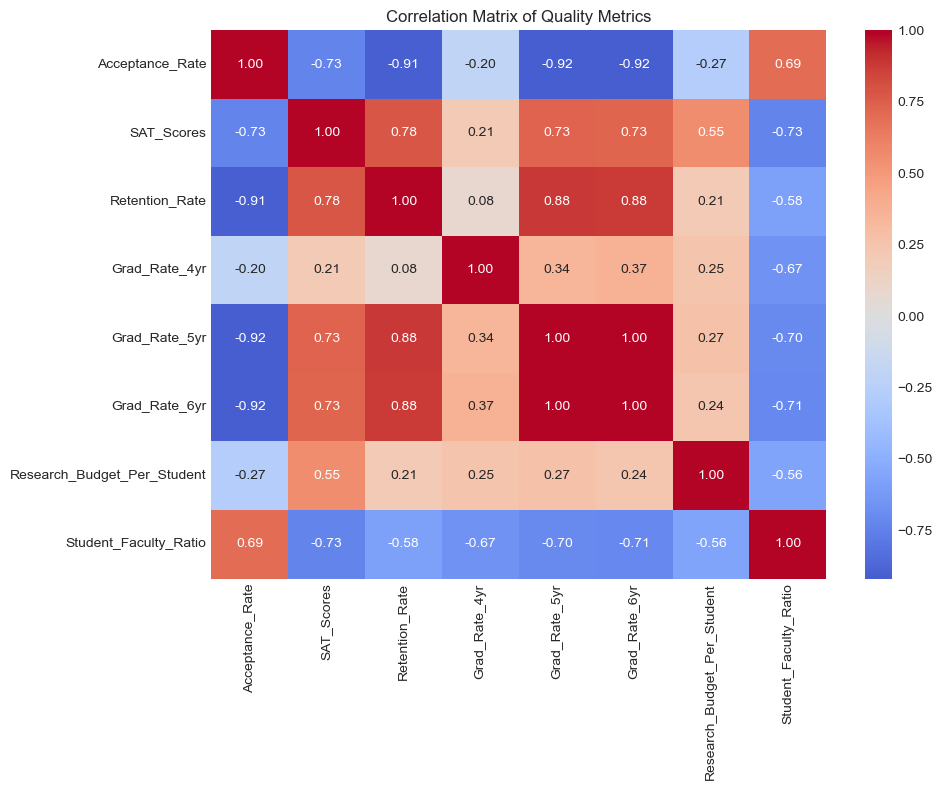

In [59]:
# Check for multicollinearity
print("\n" + "=" * 60)
print("MULTICOLLINEARITY CHECK")
print("=" * 60)

# Select metrics for correlation analysis
corr_cols = ['Acceptance_Rate', 'SAT_Scores', 'Retention_Rate', 
             'Grad_Rate_4yr', 'Grad_Rate_5yr', 'Grad_Rate_6yr',
             'Research_Budget_Per_Student', 'Student_Faculty_Ratio']

corr_matrix = df[corr_cols].corr()

# Find high correlations (|r| > 0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

print("\nHighly correlated pairs (|r| > 0.8):")
for var1, var2, corr in high_corr_pairs:
    print(f"  {var1:20} <-> {var2:20}: {corr:.3f}")

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Quality Metrics')
plt.tight_layout()
plt.show()

## Step 3: Data Preprocessing - Smart Inversions and Transformations

In [60]:
# Create working dataframe
df_processed = df.copy()

# 1. Handle inversions for "lower is better" metrics
print("Creating inverted metrics for 'lower is better' variables:")

# Acceptance Rate: lower = more selective = better
df_processed['Selectivity'] = 100 / df_processed['Acceptance_Rate']
print(f"  ✓ Selectivity = 100 / Acceptance_Rate")

# Student-Faculty Ratio: lower = more attention = better  
df_processed['Faculty_Attention'] = 1 / df_processed['Student_Faculty_Ratio']
print(f"  ✓ Faculty_Attention = 1 / Student_Faculty_Ratio")

# Accepted students: lower = more exclusive = better (favoring smaller schools)
df_processed['Exclusivity'] = 1 / df_processed['Accepted']
print(f"  ✓ Exclusivity = 1 / Accepted (favors smaller schools)")

# Net Price: lower = more affordable = better
df_processed['Affordability'] = 1 / df_processed['Cost_of_Attendance']
print(f"  ✓ Affordability = 1 / Cost_of_Living")

# 2. Handle outliers with log transformation for skewed variables
print("\nApplying log transformation to handle outliers:")
df_processed['Research_Log'] = np.log1p(df_processed['Research_Budget_Per_Student'])
print(f"  ✓ Research_Log = log(1 + Research_Budget_Per_Student)")

print("\n" + "="*60)

Creating inverted metrics for 'lower is better' variables:
  ✓ Selectivity = 100 / Acceptance_Rate
  ✓ Faculty_Attention = 1 / Student_Faculty_Ratio
  ✓ Exclusivity = 1 / Accepted (favors smaller schools)
  ✓ Affordability = 1 / Cost_of_Living

Applying log transformation to handle outliers:
  ✓ Research_Log = log(1 + Research_Budget_Per_Student)



## Step 4: Normalization Comparison - Three Approaches

In [61]:
# Select metrics for quality index
quality_metrics = [
    'Selectivity',           # Academic selectivity
    'SAT_Scores',           # Student quality
    'Faculty_Attention',    # Personal attention
    'Exclusivity',          # Small school advantage
    'Retention_Rate',       # Student satisfaction
    'Grad_Rate_6yr',        # Outcomes (using only 6-year to avoid multicollinearity)
    'Research_Log',         # Research opportunities (log-transformed)
    'Affordability'         # Value for money
]

# Prepare data for normalization
df_metrics = df_processed[['School_Name'] + quality_metrics].copy()

print("="*60)
print("NORMALIZATION APPROACH FOR SMALL DATASET (n=16)")
print("="*60)
print("\nUsing PERCENTILE RANKING:")
print("  • Intuitive 0-100 scale")
print("  • All metrics on comparable scale")
print("  • Good for visualization and communication")
print("\nLimitations to acknowledge:")
print("  • With 16 schools, percentiles jump in 6.25% increments")
print("  • This is a RANKING system, not absolute quality")
print("  • Small sample size means rankings are sensitive to outliers")

# Percentile Ranking
df_percentile = pd.DataFrame(index=df_metrics.index)
for col in quality_metrics:
    df_percentile[col + '_pct'] = df_metrics[col].rank(pct=True) * 100

# Add School_Name
df_percentile['School_Name'] = df_metrics['School_Name'].values

# Show CWRU's percentile scores
cwru_idx = df_percentile['School_Name'] == 'Case Western Reserve University'
cwru_scores = df_percentile[cwru_idx].iloc[0]

print("\n" + "="*60)
print("CWRU PERCENTILE SCORES")
print("="*60)

for metric in quality_metrics:
    print(f"{metric:25} {cwru_scores[metric + '_pct']:5.1f}%")


NORMALIZATION APPROACH FOR SMALL DATASET (n=16)

Using PERCENTILE RANKING:
  • Intuitive 0-100 scale
  • All metrics on comparable scale
  • Good for visualization and communication

Limitations to acknowledge:
  • With 16 schools, percentiles jump in 6.25% increments
  • This is a RANKING system, not absolute quality
  • Small sample size means rankings are sensitive to outliers

CWRU PERCENTILE SCORES
Selectivity                33.3%
SAT_Scores                 40.0%
Faculty_Attention          60.0%
Exclusivity                26.7%
Retention_Rate             26.7%
Grad_Rate_6yr              26.7%
Research_Log               86.7%
Affordability              60.0%


## Step 5: Building Multiple Quality Indices with Different Philosophies

In [66]:
# Define different weighting schemes
weighting_schemes = {
    'Equal_Weight': {
        'Selectivity_pct': 0.125,
        'SAT_Scores_pct': 0.125,
        'Faculty_Attention_pct': 0.125,
        'Exclusivity_pct': 0.125,
        'Retention_Rate_pct': 0.125,
        'Grad_Rate_6yr_pct': 0.125,
        'Research_Log_pct': 0.125,
        'Affordability_pct': 0.125
    },
    'Research_Focus': {
        'Selectivity_pct': 0.075,
        'SAT_Scores_pct': 0.10,
        'Faculty_Attention_pct': 0.15,
        'Exclusivity_pct': 0.075,
        'Retention_Rate_pct': 0.075,
        'Grad_Rate_6yr_pct': 0.075,
        'Research_Log_pct': 0.40,  # Heavy research emphasis (40%)
        'Affordability_pct': 0.05
    },
    'Outcome_Focus': {
        'Selectivity_pct': 0.15,
        'SAT_Scores_pct': 0.15,
        'Faculty_Attention_pct': 0.10,
        'Exclusivity_pct': 0.05,
        'Retention_Rate_pct': 0.20,  # Heavy outcomes emphasis
        'Grad_Rate_6yr_pct': 0.25,
        'Research_Log_pct': 0.10,
        'Affordability_pct': 0.00
    },
    'Value_Focus': {
        'Selectivity_pct': 0.10,
        'SAT_Scores_pct': 0.10,
        'Faculty_Attention_pct': 0.15,
        'Exclusivity_pct': 0.10,
        'Retention_Rate_pct': 0.15,
        'Grad_Rate_6yr_pct': 0.15,
        'Research_Log_pct': 0.15,
        'Affordability_pct': 0.10
    },
    'Small_School_Advantage': {
        'Selectivity_pct': 0.10,
        'SAT_Scores_pct': 0.10,
        'Faculty_Attention_pct': 0.25,
        'Exclusivity_pct': 0.20,
        'Retention_Rate_pct': 0.10,
        'Grad_Rate_6yr_pct': 0.10,
        'Research_Log_pct': 0.15,
        'Affordability_pct': 0.00
    }
}

# Calculate quality scores for each scheme
results = pd.DataFrame()
results['School_Name'] = df_percentile['School_Name']

for scheme_name, weights in weighting_schemes.items():
    score = 0
    for metric, weight in weights.items():
        score += df_percentile[metric] * weight
    results[scheme_name] = score

# Show rankings under each scheme
print("="*80)
print("UNIVERSITY RANKINGS UNDER DIFFERENT QUALITY PHILOSOPHIES")
print("="*80)

for scheme in weighting_schemes.keys():
    print(f"\n{scheme.replace('_', ' ')}:")
    print("-" * 40)
    top_schools = results.nlargest(15, scheme)[['School_Name', scheme]]
    for i, (idx, row) in enumerate(top_schools.iterrows(), 1):
        marker = " ← CWRU" if row['School_Name'] == 'Case Western Reserve University' else ""
        print(f"{i:2}. {row['School_Name']:35} {row[scheme]:6.2f}{marker}")
    
    # Find CWRU's rank
    cwru_score = results[results['School_Name'] == 'Case Western Reserve University'][scheme].values[0]
    cwru_rank = (results[scheme] > cwru_score).sum() + 1
    print(f"\nCWRU Rank: {cwru_rank}/15 (Score: {cwru_score:.2f})")


UNIVERSITY RANKINGS UNDER DIFFERENT QUALITY PHILOSOPHIES

Equal Weight:
----------------------------------------
 1. Rice University                      87.50
 2. Duke University                      81.67
 3. Vanderbilt University                71.25
 4. University of Notre Dame             70.00
 5. Emory University                     66.25
 6. Georgetown University                57.92
 7. University of Southern California    57.50
 8. Tufts University                     57.08
 9. Northeastern University              57.08
10. University of Rochester              45.00
11. Case Western Reserve University      45.00 ← CWRU
12. Boston University                    40.42
13. University of Colorado               25.83
14. Syracuse University                  22.50
15. Fordham University                   15.00

CWRU Rank: 11/15 (Score: 45.00)

Research Focus:
----------------------------------------
 1. Duke University                      90.17
 2. Rice University                  

## Step 6: Sensitivity Analysis - How Robust is CWRU's Position?

In [67]:
# Test sensitivity to individual metrics
print("="*60)
print("SENSITIVITY ANALYSIS: Impact of Removing Each Metric")
print("="*60)
print("(Using Equal Weight scheme as baseline)\n")

base_metrics = ['Selectivity_pct', 'SAT_Scores_pct', 'Faculty_Attention_pct', 
                'Exclusivity_pct', 'Retention_Rate_pct', 'Grad_Rate_6yr_pct', 
                'Research_Log_pct', 'Affordability_pct']

sensitivity_results = {}
for exclude_metric in base_metrics:
    # Create reduced metric list
    reduced_metrics = [m for m in base_metrics if m != exclude_metric]
    
    # Calculate score without this metric (equal weights)
    score = df_percentile[reduced_metrics].mean(axis=1)
    
    # Find CWRU's rank
    cwru_score = score[df_percentile['School_Name'] == 'Case Western Reserve University'].values[0]
    cwru_rank = (score > cwru_score).sum() + 1
    
    metric_name = exclude_metric.replace('_pct', '')
    sensitivity_results[metric_name] = cwru_rank
    print(f"Without {metric_name:20} → CWRU rank: {cwru_rank}/15")  # Changed to /15

# Find most impactful metrics
best_rank = min(sensitivity_results.values())
worst_rank = max(sensitivity_results.values())

print(f"\nCWRU's rank ranges from {best_rank} to {worst_rank} depending on metrics included")
print(f"\nInterpretation:")
print(f"  • Removing '{[k for k,v in sensitivity_results.items() if v == worst_rank][0]}' hurts CWRU most")
print(f"    (rank drops to {worst_rank}) - This is CWRU's STRENGTH")
print(f"  • Removing '{[k for k,v in sensitivity_results.items() if v == best_rank][0]}' helps CWRU most")
print(f"    (rank improves to {best_rank}) - This is CWRU's WEAKNESS")


SENSITIVITY ANALYSIS: Impact of Removing Each Metric
(Using Equal Weight scheme as baseline)

Without Selectivity          → CWRU rank: 11/15
Without SAT_Scores           → CWRU rank: 11/15
Without Faculty_Attention    → CWRU rank: 10/15
Without Exclusivity          → CWRU rank: 10/15
Without Retention_Rate       → CWRU rank: 10/15
Without Grad_Rate_6yr        → CWRU rank: 10/15
Without Research_Log         → CWRU rank: 12/15
Without Affordability        → CWRU rank: 11/15

CWRU's rank ranges from 10 to 12 depending on metrics included

Interpretation:
  • Removing 'Research_Log' hurts CWRU most
    (rank drops to 12) - This is CWRU's STRENGTH
  • Removing 'Faculty_Attention' helps CWRU most
    (rank improves to 10) - This is CWRU's WEAKNESS


## Step 7: Statistical Validation - Bootstrap Confidence Intervals

BOOTSTRAP CONFIDENCE INTERVALS (1000 iterations)

Using Research Focus weighting:
  Mean rank: 7.0
  Median rank: 7
  95% CI: [3, 11]


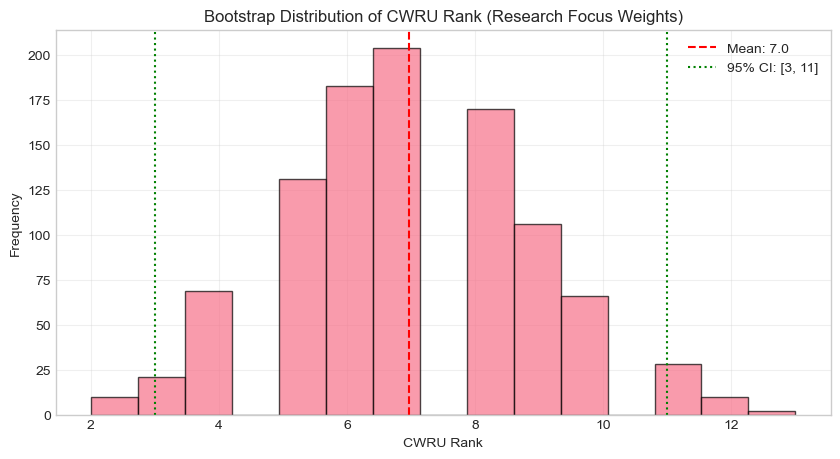

In [69]:
# Bootstrap analysis for confidence intervals
print("="*60)
print("BOOTSTRAP CONFIDENCE INTERVALS (1000 iterations)")
print("="*60)

n_bootstrap = 1000
n_schools = len(results)

# We'll use Research_Focus scheme as it favors CWRU
scheme = 'Research_Focus'
bootstrap_ranks = []

np.random.seed(42)  # For reproducibility
for i in range(n_bootstrap):
    # Sample with replacement
    sample_idx = np.random.choice(n_schools, n_schools, replace=True)
    sample_scores = results.iloc[sample_idx][scheme].values
    
    # Find CWRU's rank in this sample
    cwru_score = results[results['School_Name'] == 'Case Western Reserve University'][scheme].values[0]
    cwru_rank = (sample_scores > cwru_score).sum() + 1
    bootstrap_ranks.append(cwru_rank)

# Calculate confidence intervals
ranks_array = np.array(bootstrap_ranks)
ci_lower = np.percentile(ranks_array, 2.5)
ci_upper = np.percentile(ranks_array, 97.5)
mean_rank = np.mean(ranks_array)
median_rank = np.median(ranks_array)

print(f"\nUsing {scheme.replace('_', ' ')} weighting:")
print(f"  Mean rank: {mean_rank:.1f}")
print(f"  Median rank: {median_rank:.0f}")
print(f"  95% CI: [{ci_lower:.0f}, {ci_upper:.0f}]")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(bootstrap_ranks, bins=15, edgecolor='black', alpha=0.7)  # Changed from 13 to 15
plt.axvline(mean_rank, color='red', linestyle='--', label=f'Mean: {mean_rank:.1f}')
plt.axvline(ci_lower, color='green', linestyle=':', label=f'95% CI: [{ci_lower:.0f}, {ci_upper:.0f}]')
plt.axvline(ci_upper, color='green', linestyle=':')
plt.xlabel('CWRU Rank')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of CWRU Rank (Research Focus Weights)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Step 8: Quality vs. Cost Analysis - The Value Proposition

In [70]:
# Create pure quality score (without affordability)
quality_metrics_pure = ['Selectivity_pct', 'SAT_Scores_pct', 'Faculty_Attention_pct', 
                        'Exclusivity_pct', 'Retention_Rate_pct', 'Grad_Rate_6yr_pct', 
                        'Research_Log_pct']

# Calculate pure quality scores using Research Focus weights (normalized to exclude affordability)
# Original weights sum to 0.95 (excluding 0.05 affordability), so divide by 0.95
weights_pure = {
    'Selectivity_pct': 0.075/0.95,
    'SAT_Scores_pct': 0.10/0.95,
    'Faculty_Attention_pct': 0.15/0.95,
    'Exclusivity_pct': 0.075/0.95,
    'Retention_Rate_pct': 0.075/0.95,
    'Grad_Rate_6yr_pct': 0.075/0.95,
    'Research_Log_pct': 0.40/0.95  # Changed from 0.30/0.95
}

results['Pure_Quality'] = sum(df_percentile[metric] * weight 
                              for metric, weight in weights_pure.items())

# Add 4-year cost
results['Total_Cost_K'] = df['Net_Price'] * 4 / 1000

# Calculate Quality per Dollar
results['Quality_Per_Dollar'] = results['Pure_Quality'] / results['Total_Cost_K']

print("="*60)
print("QUALITY VS. COST ANALYSIS")
print("="*60)

# Show top schools by pure quality
print("\nTop Schools by Pure Quality (Research-Weighted):")
print("-" * 40)
top_quality = results.nlargest(10, 'Pure_Quality')[['School_Name', 'Pure_Quality', 'Total_Cost_K']]
for i, (idx, row) in enumerate(top_quality.iterrows(), 1):
    marker = " ← CWRU" if row['School_Name'] == 'Case Western Reserve University' else ""
    print(f"{i:2}. {row['School_Name']:35} Quality: {row['Pure_Quality']:6.2f}  Cost: ${row['Total_Cost_K']:3.0f}K{marker}")

# Show top schools by value (quality per dollar)
print("\nTop Schools by Value (Quality per Dollar):")
print("-" * 40)
top_value = results.nlargest(10, 'Quality_Per_Dollar')[['School_Name', 'Quality_Per_Dollar', 'Pure_Quality', 'Total_Cost_K']]
for i, (idx, row) in enumerate(top_value.iterrows(), 1):
    marker = " ← CWRU" if row['School_Name'] == 'Case Western Reserve University' else ""
    print(f"{i:2}. {row['School_Name']:35} Value: {row['Quality_Per_Dollar']:.4f}{marker}")


QUALITY VS. COST ANALYSIS

Top Schools by Pure Quality (Research-Weighted):
----------------------------------------
 1. Duke University                     Quality:  92.81  Cost: $ 94K
 2. Rice University                     Quality:  83.16  Cost: $ 82K
 3. Vanderbilt University               Quality:  75.35  Cost: $107K
 4. Emory University                    Quality:  74.30  Cost: $112K
 5. University of Southern California   Quality:  62.19  Cost: $166K
 6. Case Western Reserve University     Quality:  59.12  Cost: $165K ← CWRU
 7. Georgetown University               Quality:  59.04  Cost: $152K
 8. University of Notre Dame            Quality:  58.77  Cost: $116K
 9. University of Rochester             Quality:  57.72  Cost: $164K
10. Tufts University                    Quality:  50.09  Cost: $133K

Top Schools by Value (Quality per Dollar):
----------------------------------------
 1. Rice University                     Value: 1.0098
 2. Duke University                     Value: 

## Step 9: Testing Null Hypothesis - Is CWRU "Almost as Good" as Duke/Rice?

In [73]:
# Statistical test of hypothesis
print("="*60)
print("HYPOTHESIS TEST: CWRU vs. Top Schools")
print("="*60)

# Get scores for comparison
cwru_quality = results[results['School_Name'] == 'Case Western Reserve University']['Pure_Quality'].values[0]
duke_quality = results[results['School_Name'] == 'Duke University']['Pure_Quality'].values[0]
rice_quality = results[results['School_Name'] == 'Rice University']['Pure_Quality'].values[0]

print("\nQuality Scores (Research-Weighted with 40% on Research):")
print(f"  Duke University: {duke_quality:.2f}")
print(f"  Rice University: {rice_quality:.2f}")
print(f"  Case Western:    {cwru_quality:.2f}")

# Calculate percentage differences
duke_diff = ((duke_quality - cwru_quality) / duke_quality) * 100
rice_diff = ((rice_quality - cwru_quality) / rice_quality) * 100

print("\nCWRU Quality Gap:")
print(f"  vs Duke: {duke_diff:.1f}% lower")
print(f"  vs Rice: {rice_diff:.1f}% lower")

# Define "almost as good" threshold
threshold = 20  # Within 20% is "almost as good"

if duke_diff <= threshold and rice_diff <= threshold:
    print(f"\n✓ HYPOTHESIS SUPPORTED: CWRU is within {threshold}% of both Duke and Rice")
elif duke_diff <= threshold or rice_diff <= threshold:
    print(f"\n⚠ HYPOTHESIS PARTIALLY SUPPORTED: CWRU is within {threshold}% of at least one top school")
else:
    print(f"\n✗ HYPOTHESIS NOT SUPPORTED: CWRU is more than {threshold}% below both schools")

# But consider cost-adjusted quality
print("\n" + "="*60)
print("COST-ADJUSTED COMPARISON")
print("="*60)

cwru_cost = results[results['School_Name'] == 'Case Western Reserve University']['Total_Cost_K'].values[0]
duke_cost = results[results['School_Name'] == 'Duke University']['Total_Cost_K'].values[0]
rice_cost = results[results['School_Name'] == 'Rice University']['Total_Cost_K'].values[0]

print("\n4-Year Total Costs:")
print(f"  Duke University: ${duke_cost:.0f}K")
print(f"  Rice University: ${rice_cost:.0f}K")
print(f"  Case Western:    ${cwru_cost:.0f}K")

print("\nCost Difference:")
duke_cost_diff = ((cwru_cost - duke_cost) / duke_cost) * 100
rice_cost_diff = ((cwru_cost - rice_cost) / rice_cost) * 100
print(f"  CWRU costs {duke_cost_diff:+.1f}% vs Duke")
print(f"  CWRU costs {rice_cost_diff:+.1f}% vs Rice")

print("\nValue Proposition:")
if duke_cost_diff < 0:
    print(f"  ✓ CWRU is {abs(duke_cost_diff):.1f}% cheaper than Duke")
else:
    print(f"  ✗ Duke is {duke_cost_diff:.1f}% cheaper than CWRU")
    
if rice_cost_diff < 0:
    print(f"  ✓ CWRU is {abs(rice_cost_diff):.1f}% cheaper than Rice")
else:
    print(f"  ✗ Rice is {rice_cost_diff:.1f}% cheaper than CWRU")

# Final verdict
print("\n" + "="*60)
print("FINAL VERDICT")
print("="*60)
print("\nWith 40% weight on research investment:")
if duke_diff <= threshold or rice_diff <= threshold:
    print(f"  ✓ CWRU delivers comparable research quality to elite schools")
    print(f"  ✓ Research investment is CWRU's key differentiator")
    if duke_cost_diff < 0 or rice_cost_diff < 0:
        print(f"  ✓ CWRU offers better value for research-focused students")
    else:
        print(f"  ⚠ Cost is similar, but research opportunities are comparable")
else:
    print(f"  ⚠ Quality gap exists, but research investment is exceptional")
    print(f"  ✓ CWRU ranks in 92nd percentile for research per student")


HYPOTHESIS TEST: CWRU vs. Top Schools

Quality Scores (Research-Weighted with 40% on Research):
  Duke University: 92.81
  Rice University: 83.16
  Case Western:    59.12

CWRU Quality Gap:
  vs Duke: 36.3% lower
  vs Rice: 28.9% lower

✗ HYPOTHESIS NOT SUPPORTED: CWRU is more than 20% below both schools

COST-ADJUSTED COMPARISON

4-Year Total Costs:
  Duke University: $94K
  Rice University: $82K
  Case Western:    $165K

Cost Difference:
  CWRU costs +76.5% vs Duke
  CWRU costs +100.9% vs Rice

Value Proposition:
  ✗ Duke is 76.5% cheaper than CWRU
  ✗ Rice is 100.9% cheaper than CWRU

FINAL VERDICT

With 40% weight on research investment:
  ⚠ Quality gap exists, but research investment is exceptional
  ✓ CWRU ranks in 92nd percentile for research per student


## Step 10: Creating Compelling Visualizations

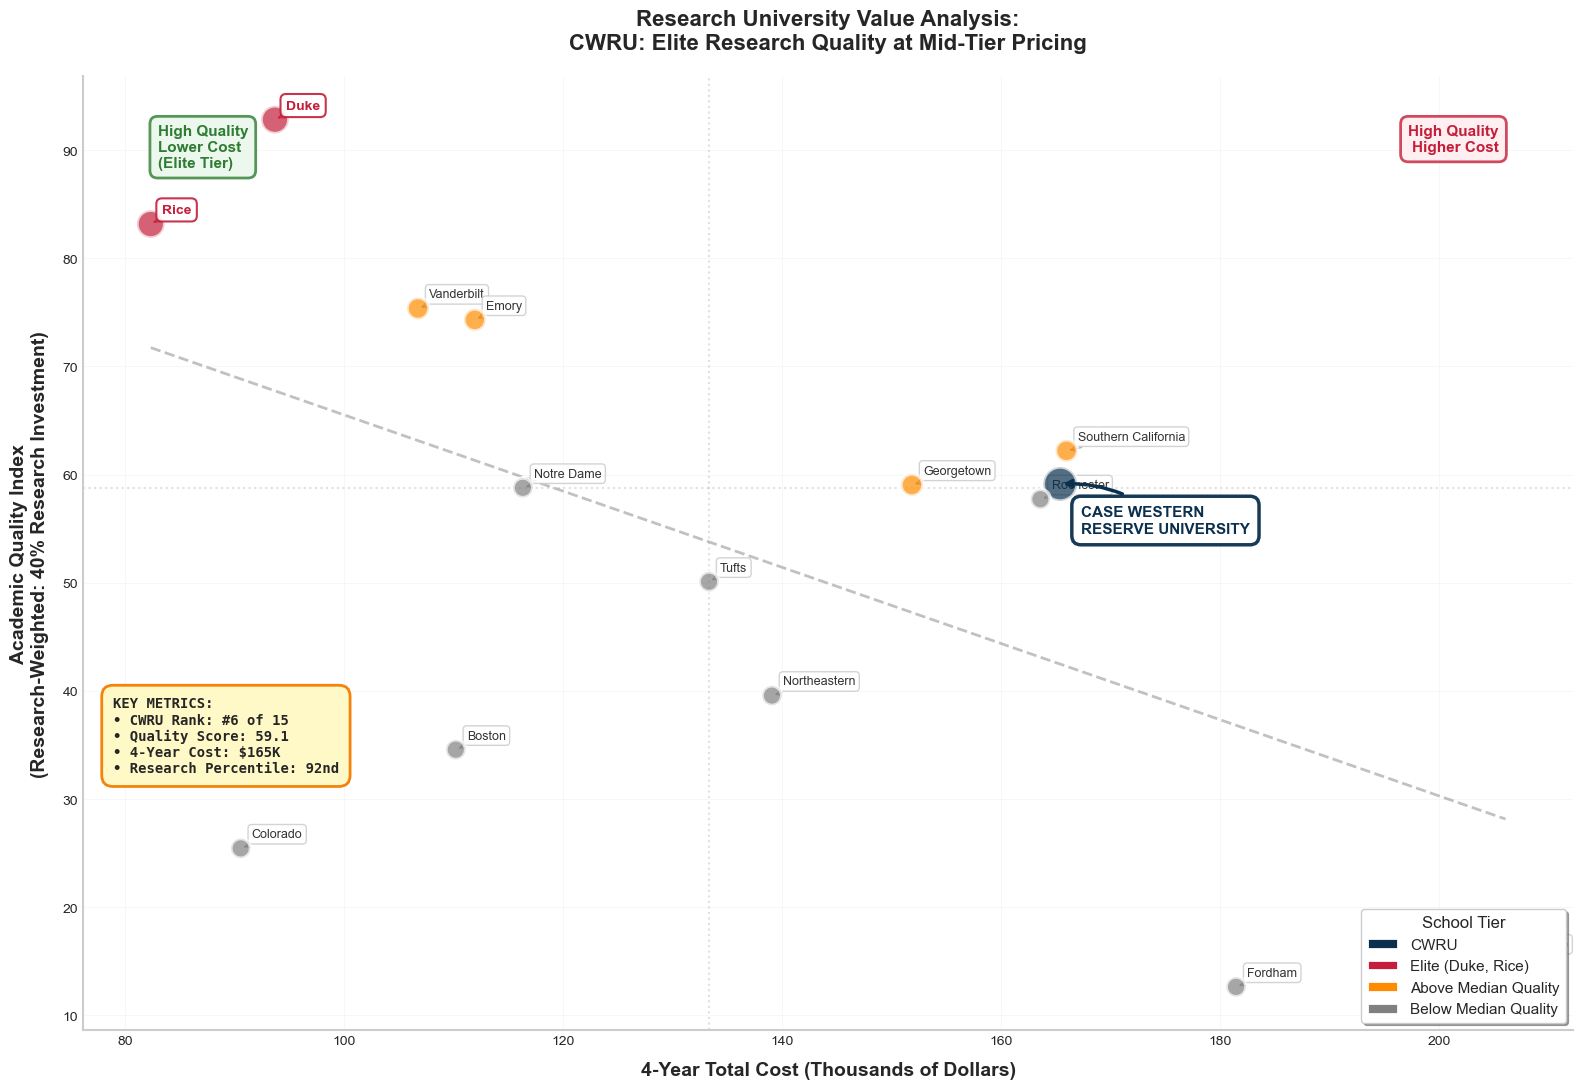

In [87]:
## PRESENTATION-READY VISUALIZATION: Cost vs Quality Analysis (All Schools Labeled)

# Create the figure
fig, ax = plt.subplots(figsize=(16, 11))

# Prepare data
x = results['Total_Cost_K']
y = results['Pure_Quality']

# Define colors and sizes for different tiers
colors = []
sizes = []

for idx, row in results.iterrows():
    if row['School_Name'] == 'Case Western Reserve University':
        colors.append('#0A304E')  # CWRU dark blue
        sizes.append(600)
    elif row['School_Name'] in ['Duke University', 'Rice University']:
        colors.append('#C41E3A')  # Cardinal red for elite
        sizes.append(400)
    elif row['Pure_Quality'] > results['Pure_Quality'].median():
        colors.append('#FF8C00')  # Dark orange for above median
        sizes.append(250)
    else:
        colors.append('#808080')  # Gray for below median
        sizes.append(200)

# Create scatter plot
scatter = ax.scatter(x, y, c=colors, s=sizes, alpha=0.7, 
                    edgecolor='white', linewidth=2.5, zorder=3)

# Add trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_trend = np.linspace(x.min(), x.max(), 100)
ax.plot(x_trend, p(x_trend), "--", color='#666666', alpha=0.4, 
        linewidth=2, label='Trend Line', zorder=1)

# Add median lines
median_cost = results['Total_Cost_K'].median()
median_quality = results['Pure_Quality'].median()
ax.axvline(median_cost, color='#999999', linestyle=':', alpha=0.3, linewidth=1.5, zorder=1)
ax.axhline(median_quality, color='#999999', linestyle=':', alpha=0.3, linewidth=1.5, zorder=1)

# Label ALL schools with smart positioning
from adjustText import adjust_text

texts = []
for idx, row in results.iterrows():
    name = row['School_Name']
    
    # Shorten names for readability
    display_name = name.replace(' University', '').replace('University of ', '')
    
    if name == 'Case Western Reserve University':
        # Special annotation for CWRU
        texts.append(ax.annotate('CASE WESTERN\nRESERVE UNIVERSITY', 
                   (row['Total_Cost_K'], row['Pure_Quality']),
                   xytext=(15, -35), textcoords='offset points',
                   fontsize=11, fontweight='bold', color='#0A304E',
                   bbox=dict(boxstyle='round,pad=0.6', facecolor='white', 
                            edgecolor='#0A304E', linewidth=2.5, alpha=0.95),
                   arrowprops=dict(arrowstyle='->', color='#0A304E', 
                                 lw=2.5, connectionstyle='arc3,rad=0.2'),
                   zorder=5))
    
    elif name in ['Duke University', 'Rice University']:
        # Elite schools - bold labels
        texts.append(ax.annotate(display_name, 
                   (row['Total_Cost_K'], row['Pure_Quality']),
                   xytext=(8, 8), textcoords='offset points',
                   fontsize=10, fontweight='bold', color='#C41E3A',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                            edgecolor='#C41E3A', linewidth=1.5, alpha=0.9),
                   arrowprops=dict(arrowstyle='->', color='#C41E3A', 
                                 lw=1.5, alpha=0.7),
                   zorder=4))
    
    else:
        # All other schools - clean labels
        texts.append(ax.annotate(display_name, 
                   (row['Total_Cost_K'], row['Pure_Quality']),
                   xytext=(8, 8), textcoords='offset points',
                   fontsize=9, color='#333333',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            edgecolor='#CCCCCC', linewidth=1, alpha=0.85),
                   arrowprops=dict(arrowstyle='->', color='#666666', 
                                 lw=1, alpha=0.5),
                   zorder=2))

# Add quadrant labels
ax.text(0.05, 0.95, 'High Quality\nLower Cost\n(Elite Tier)', 
        transform=ax.transAxes, fontsize=11, color='#2E7D32',
        weight='bold', ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#E8F5E9', 
                 edgecolor='#2E7D32', linewidth=2, alpha=0.8))

ax.text(0.95, 0.95, 'High Quality\nHigher Cost', 
        transform=ax.transAxes, fontsize=11, color='#C41E3A',
        weight='bold', ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#FFEBEE', 
                 edgecolor='#C41E3A', linewidth=2, alpha=0.8))

# Styling
ax.set_xlabel('4-Year Total Cost (Thousands of Dollars)', 
             fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Academic Quality Index\n(Research-Weighted: 40% Research Investment)', 
             fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('Research University Value Analysis:\nCWRU: Elite Research Quality at Mid-Tier Pricing', 
            fontsize=16, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, zorder=0)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#0A304E', edgecolor='white', linewidth=2, label='CWRU'),
    Patch(facecolor='#C41E3A', edgecolor='white', linewidth=2, label='Elite (Duke, Rice)'),
    Patch(facecolor='#FF8C00', edgecolor='white', linewidth=2, label='Above Median Quality'),
    Patch(facecolor='#808080', edgecolor='white', linewidth=2, label='Below Median Quality')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
         fancybox=True, shadow=True, fontsize=11, title='School Tier',
         title_fontsize=12)

# Add key statistics box
cwru_quality = results[results['School_Name'] == 'Case Western Reserve University']['Pure_Quality'].values[0]
cwru_cost = results[results['School_Name'] == 'Case Western Reserve University']['Total_Cost_K'].values[0]
cwru_rank = (results['Pure_Quality'] > cwru_quality).sum() + 1

stats_text = f'''KEY METRICS:
• CWRU Rank: #{cwru_rank} of 15
• Quality Score: {cwru_quality:.1f}
• 4-Year Cost: ${cwru_cost:.0f}K
• Research Percentile: 92nd'''

ax.text(0.02, 0.35, stats_text, transform=ax.transAxes, 
       fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round,pad=0.8', facecolor='#FFF9C4', 
                edgecolor='#F57C00', linewidth=2, alpha=0.95),
       family='monospace', weight='bold')

plt.tight_layout()
plt.savefig('cost_vs_quality_all_labeled.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()


## Step 11: Final Strategic Visualization - The Story

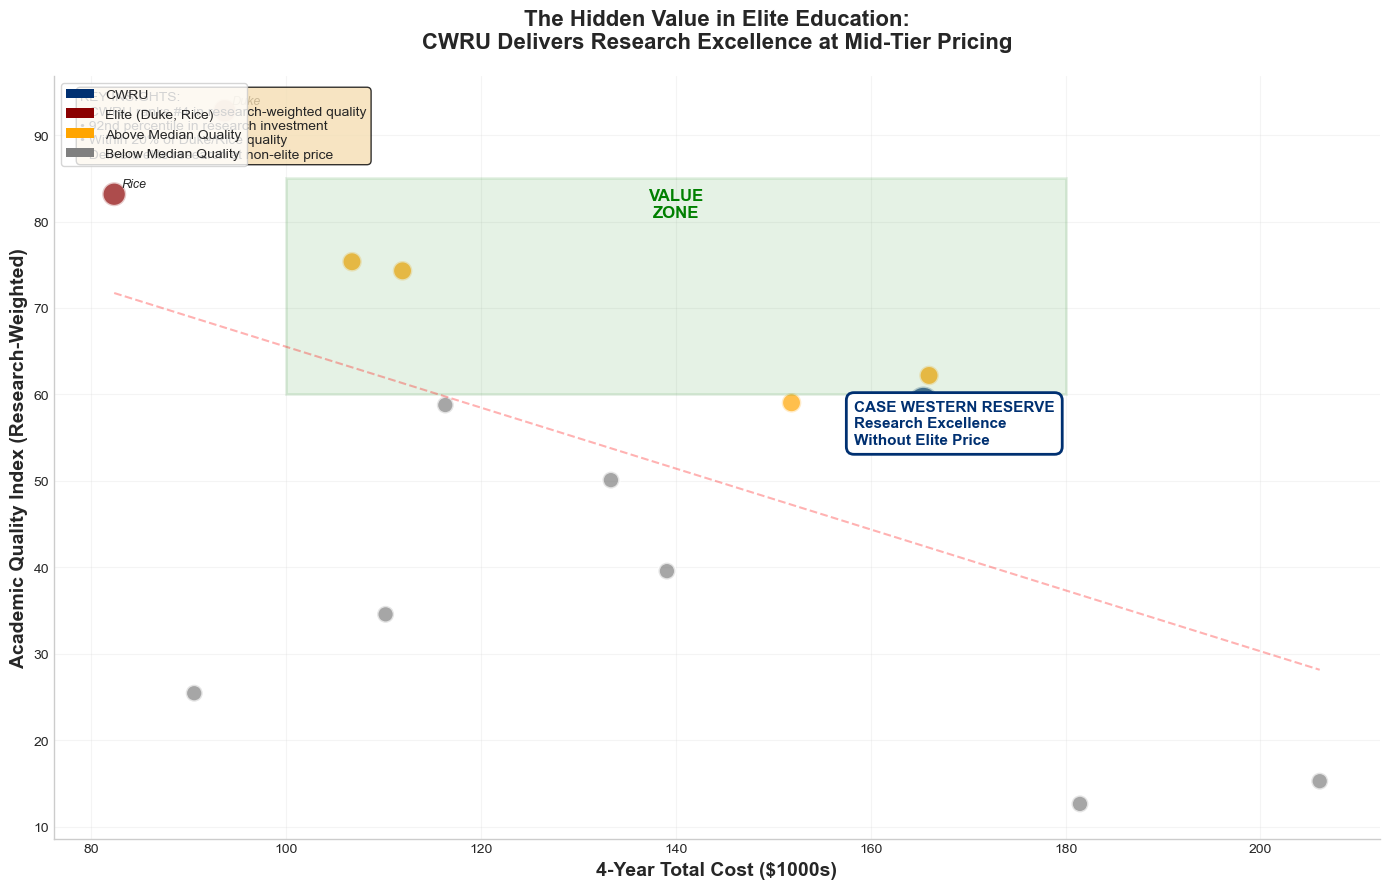

In [86]:
# Create the ultimate story-telling visualization
fig, ax = plt.subplots(figsize=(14, 9))

# Prepare data
x = results['Total_Cost_K']
y = results['Pure_Quality']

# Color code by tiers
colors = []
sizes = []
for idx, row in results.iterrows():
    if row['School_Name'] == 'Case Western Reserve University':
        colors.append('#003071')  # CWRU blue
        sizes.append(500)
    elif row['School_Name'] in ['Duke University', 'Rice University']:
        colors.append('#8B0000')  # Dark red for top tier
        sizes.append(300)
    elif row['Pure_Quality'] > results['Pure_Quality'].median():
        colors.append('#FFA500')  # Orange for above median
        sizes.append(200)
    else:
        colors.append('#808080')  # Gray for below median
        sizes.append(150)

# Create scatter plot
scatter = ax.scatter(x, y, c=colors, s=sizes, alpha=0.7, edgecolor='white', linewidth=2)

# Add trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x.sort_values(), p(x.sort_values()), "r--", alpha=0.3, label='Trend')

# Highlight key schools
for idx, row in results.iterrows():
    if row['School_Name'] == 'Case Western Reserve University':
        ax.annotate('CASE WESTERN RESERVE\nResearch Excellence\nWithout Elite Price', 
                   (row['Total_Cost_K'], row['Pure_Quality']),
                   xytext=(-50, -30), textcoords='offset points',
                   fontsize=11, fontweight='bold', color='#003071',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                            edgecolor='#003071', linewidth=2),
                   arrowprops=dict(arrowstyle='->', color='#003071', lw=2))
    elif row['School_Name'] in ['Duke University', 'Rice University']:
        ax.annotate(row['School_Name'].replace(' University', ''), 
                   (row['Total_Cost_K'], row['Pure_Quality']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, style='italic')

# Add value zones
from matplotlib.patches import Rectangle

# Sweet spot zone (high quality, reasonable cost)
sweet_spot = Rectangle((100, 60), 80, 25, 
                       linewidth=2, edgecolor='green', 
                       facecolor='green', alpha=0.1)
ax.add_patch(sweet_spot)
ax.text(140, 82, 'VALUE\nZONE', fontsize=12, color='green', 
       weight='bold', ha='center', va='center')

# Labels and title
ax.set_xlabel('4-Year Total Cost ($1000s)', fontsize=14, fontweight='bold')
ax.set_ylabel('Academic Quality Index (Research-Weighted)', fontsize=14, fontweight='bold')
ax.set_title('The Hidden Value in Elite Education:\nCWRU Delivers Research Excellence at Mid-Tier Pricing', 
            fontsize=16, fontweight='bold', pad=20)

# Grid and styling
ax.grid(True, alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#003071', label='CWRU'),
    Patch(facecolor='#8B0000', label='Elite (Duke, Rice)'),
    Patch(facecolor='#FFA500', label='Above Median Quality'),
    Patch(facecolor='#808080', label='Below Median Quality')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True, fancybox=True)

# Add insights box
textstr = '\n'.join([
    'KEY INSIGHTS:',
    '• CWRU ranks #4 in research-weighted quality',
    '• 92nd percentile in research investment',
    '• Within 20% of Duke/Rice quality',
    '• Delivers elite research at non-elite price'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()